In [1]:
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.image as mpimg

In [4]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[]


In [2]:
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

GPU Available:  []


In [11]:
TRAIN_DIR = 'data/train'
VAL_DIR = 'data/validation'

train_muffin_dir = os.path.join(TRAIN_DIR, 'muffin')
train_chihuahua_dir = os.path.join(TRAIN_DIR, 'chihuahua')

val_chihuahua_dir = os.path.join(VAL_DIR, 'chihuahua')
val_muffin_dir = os.path.join(VAL_DIR, 'muffin')

In [12]:
print(f"total training muffin images: {len(os.listdir(train_muffin_dir))}")
print(f"total training chihuahua images: {len(os.listdir(train_chihuahua_dir))}")

total training muffin images: 2174
total training chihuahua images: 2559


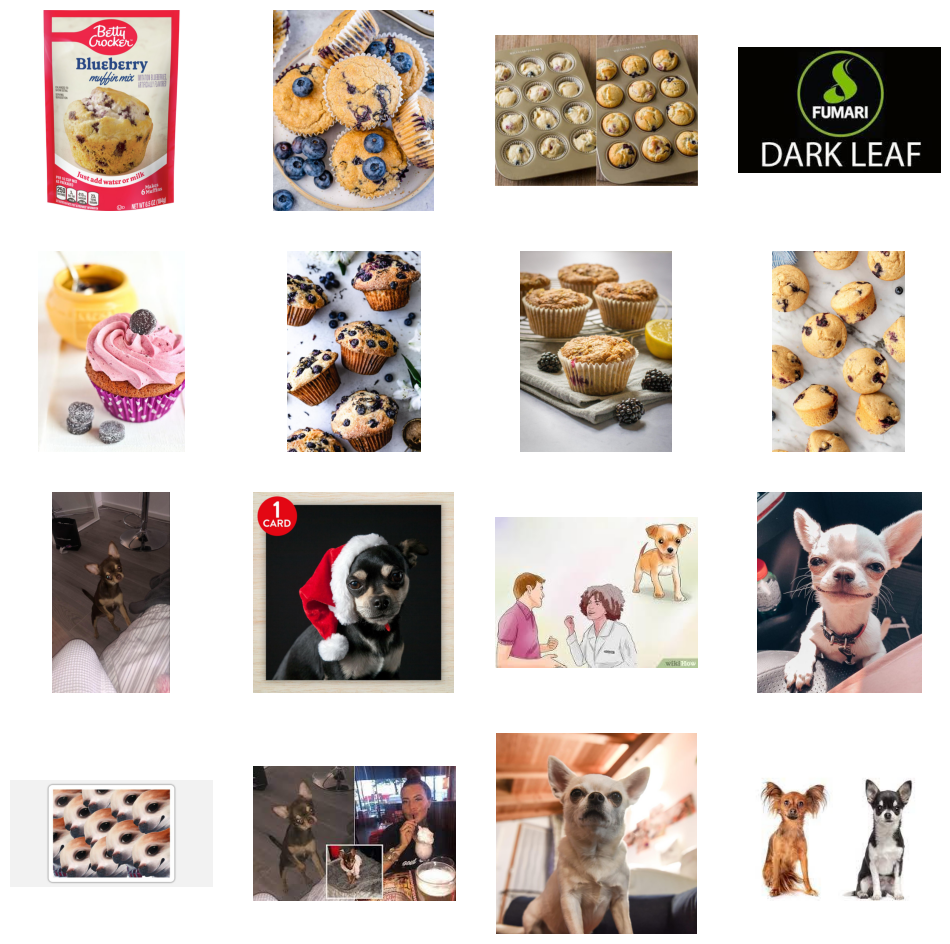

In [13]:
fig = plt.gcf()
fig.set_size_inches(ncols * 3, nrows * 3)

# Fix: Get list of files first, then sample from that list
muffin_files = os.listdir(train_muffin_dir)
chihuahua_files = os.listdir(train_chihuahua_dir)

next_muffin_pix = [os.path.join(train_muffin_dir, fname)
                   for fname in random.sample(muffin_files, k=8)]
next_chihuahua_pix = [os.path.join(train_chihuahua_dir, fname)
                      for fname in random.sample(chihuahua_files, k=8)]

for i, img_path in enumerate(next_muffin_pix + next_chihuahua_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')  # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [23]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(300,300,3)),
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(16,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])
    return model


In [15]:
BATCH_SIZE = 32
IMAGE_SIZE = (300,300)
LABEL_MODE = 'binary'

train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode=LABEL_MODE
    )

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode=LABEL_MODE
    )

Found 4733 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.


In [16]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = (train_dataset
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       )

validation_dataset_final = (validation_dataset
                            .cache()
                            .prefetch(PREFETCH_BUFFER_SIZE)
                            )

In [17]:
data_augmentation = tf.keras.Sequential([
    tf.keras.Input(shape=(300,300,3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2, fill_mode='nearest'),
    tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode='nearest'),
    tf.keras.layers.RandomZoom(0.2, fill_mode='nearest')
])

In [18]:
def demo_augmentation(sample_image, model, num_aug):

    image_preview = []

    sample_image_pil = tf.keras.utils.array_to_img(sample_image)

    image_preview.append(sample_image_pil)

    for i in range(NUM_AUG):
        sample_image_aug = model(tf.expand_dims(sample_image, axis=0))
        sample_image_aug_pil = tf.keras.utils.array_to_img(tf.squeeze(sample_image_aug))
        image_preview.append(sample_image_aug_pil)

    fig, axes = plt.subplots(1, NUM_AUG + 1, figsize=(12, 12))

    for index, ax in enumerate(axes):
        ax.imshow(image_preview[index])
        ax.set_axis_off()

        if index == 0:
            ax.set_title('original')
        else:
            ax.set_title(f'augment {index}')

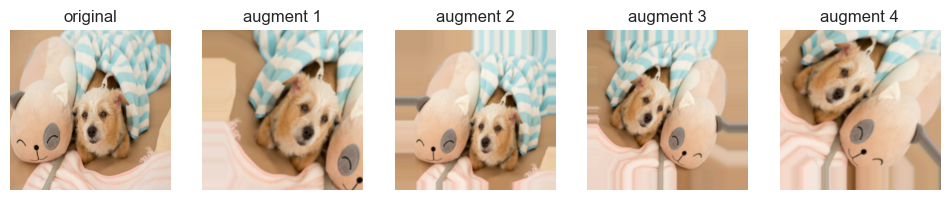

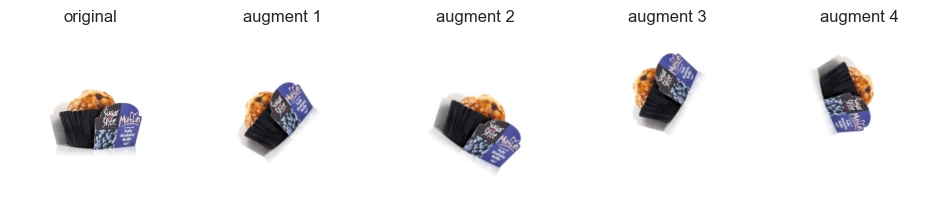

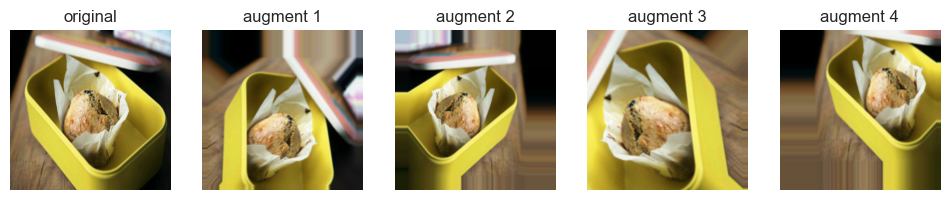

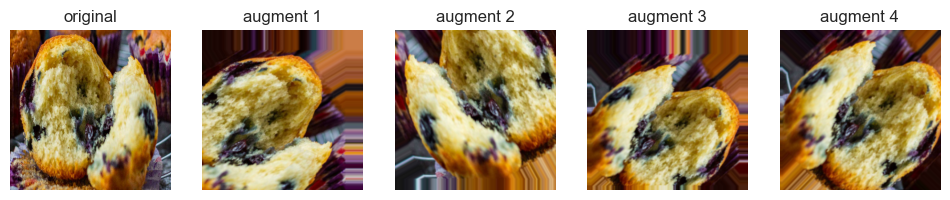

In [21]:
NUM_AUG = 4

sample_batch = list(train_dataset.take(1))[0][0]

demo_augmentation(sample_batch[0], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[1], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[2], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[3], data_augmentation, NUM_AUG)

del sample_batch

In [24]:
model_without_aug = create_model()

model_with_aug = tf.keras.models.Sequential([
    data_augmentation,
    model_without_aug
])

model_with_aug.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

In [25]:
EPOCHS = 20

history = model_with_aug.fit(
      train_dataset_final,
      epochs=EPOCHS,
      verbose=2,
      validation_data = validation_dataset_final)

Epoch 1/20
148/148 - 47s - 319ms/step - accuracy: 0.6195 - loss: 0.6442 - val_accuracy: 0.7517 - val_loss: 0.5293
Epoch 2/20
148/148 - 39s - 264ms/step - accuracy: 0.7220 - loss: 0.5502 - val_accuracy: 0.7889 - val_loss: 0.4720
Epoch 3/20
148/148 - 36s - 243ms/step - accuracy: 0.7494 - loss: 0.5189 - val_accuracy: 0.7829 - val_loss: 0.4794
Epoch 4/20
148/148 - 35s - 239ms/step - accuracy: 0.7613 - loss: 0.4983 - val_accuracy: 0.7728 - val_loss: 0.4706
Epoch 5/20
148/148 - 35s - 238ms/step - accuracy: 0.7855 - loss: 0.4762 - val_accuracy: 0.7897 - val_loss: 0.4515
Epoch 6/20


KeyboardInterrupt: 